<a href="https://colab.research.google.com/github/narim08/Artificial-Intelligence/blob/main/2022202065_AI_project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
import sys
sys.executable

'/usr/bin/python3'

# Utils
### - Implement

In [3]:
def get_available_actions(state, grid_reward):
    grid_size = len(grid_reward)
    actions = []
    row, col = state

    if row > 0:
      actions.append(ACTION_UP)
    if row < grid_size - 1:
      actions.append(ACTION_DOWN)
    if col > 0:
      actions.append(ACTION_LEFT)
    if col < grid_size - 1:
       actions.append(ACTION_RIGHT)

    return actions


def get_transition(state, action, grid_reward):
    row, col = state

    if action == ACTION_UP:
      next_state = (row-1, col)
    elif action == ACTION_DOWN:
      next_state = (row+1, col)
    elif action == ACTION_LEFT:
      next_state = (row, col-1)
    elif action == ACTION_RIGHT:
      next_state = (row, col+1)

    next_row, next_col = next_state
    reward = grid_reward[next_row, next_col]

    return next_state, reward

# Utils
### - Given

In [4]:
def generate_grid_world(obstacles):
    grid_size = 7
    grid_reward = np.full((grid_size, grid_size), -1)

    for (x, y) in obstacles:
        grid_reward[x, y] = -100

    # Define start and end positions
    start = (0, 0)
    end = (6, 6)
    grid_reward[end[0], end[1]] = 0

    return grid_reward, start, end

def print_policy(policy):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ')
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            else:
                policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
    for row in policy_symbols:
        print(' '.join(row))

def visualize_map(data, title):
    plt.imshow(data, cmap='gray', interpolation='nearest')
    plt.colorbar(label='Value')
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            plt.text(j, i, f"{data[i, j]:.1f}", ha="center", va="center", color="Green")
    plt.title(title)
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

def visualize_policy(policy, start, end, title, israndom):
    grid_size = policy.shape[0]
    policy_symbols = np.full((grid_size, grid_size), ' ', dtype="U10")
    for x in range(grid_size):
        for y in range(grid_size):
            if (x, y) == (end[0], end[1]):
                policy_symbols[x, y] = 'G'  # Goal
            elif (x, y) == (start[0], start[1]):
                policy_symbols[x, y] = 'S'  # Start
            else:
                if israndom:
                    policy_symbols[x, y] = ACTION_SYMBOLS.get(policy[x, y], ' ')
                else:
                    temp_policy_symbol = 0
                    actions = [int(value) for value in str(policy[x, y])]
                    for i, value in enumerate(actions):
                        if i == 0:
                            temp_policy_symbol = ACTION_SYMBOLS.get(value, ' ')
                        else:
                            temp_policy_symbol += ACTION_SYMBOLS.get(value, ' ')
                    policy_symbols[x, y] = temp_policy_symbol

    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_xlim(0, grid_size)
    ax.set_ylim(0, grid_size)
    ax.set_xticks(np.arange(0, grid_size+1, 1))
    ax.set_yticks(np.arange(0, grid_size+1, 1))
    ax.set_yticklabels(np.arange(grid_size, -1, -1))
    ax.grid(True)

    for x in range(grid_size):
        for y in range(grid_size):
            if israndom:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=20)
            else:
                ax.text(y + 0.5, grid_size - x - 0.5, policy_symbols[x, y],
                        ha='center', va='center', fontsize=10)
            if grid[x, y] == -100:
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='black')
                ax.add_patch(rect)
            elif (x, y) == (end[0], end[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='green', alpha=0.3)
                ax.add_patch(rect)
            elif (x, y) == (start[0], start[1]):
                rect = plt.Rectangle((y, grid_size - x - 1), 1, 1, facecolor='blue', alpha=0.3)
                ax.add_patch(rect)

    plt.title(title)
    plt.show()

# Policy initialization
### - Implement

In [5]:
def policy_generator(grid_reward, israndom, isall=False):
    grid_size = len(grid_reward)

    if israndom:
      policy = np.zeros((grid_size, grid_size), dtype=int)
    else: #isall
      policy = np.zeros((grid_size, grid_size), dtype=object)

    for row in range(grid_size):
      for col in range(grid_size):
        if grid_reward[row, col] == 0: #end state
          policy[row, col] = ACTION_UP if israndom else [0.0] * len(ACTIONS)
          continue

        act = get_available_actions((row, col), grid_reward)
        if not act:
          policy[row, col] = ACTION_UP if israndom else [0.0] * len(ACTIONS)
          continue


        if israndom:
          policy[row, col] = np.random.choice(act)
        else: #isall
          allProb = [0.0] * len(ACTIONS)
          prob = 1.0 / len(act)

          for action in act:
            allProb[action] = prob

          policy[row, col] = allProb


    return policy

# Policy evaluation
### - Implement

In [6]:
def policy_evaluation(grid_reward, policy, discount_factor=0.9, theta=1e-1, israndom=True):
    grid_size = len(grid_reward)
    V = np.zeros((grid_size, grid_size)) #value function

    while True:
      V_temp = np.zeros_like(V)
      delta = 0

      for row in range(grid_size):
        for col in range(grid_size):
          if grid_reward[row, col] == 0: #end state
            V_temp[row, col] = 0
            continue

          if grid_reward[row, col] == -100:
            V_temp[row, col] = -100
            continue


          if israndom: #single action
            act = policy[row, col]
            next_state, reward = get_transition((row, col), act, grid_reward)
            value = reward + discount_factor * V[next_state[0], next_state[1]]
          else:
            value = 0
            act_probs = policy[row, col]
            for act, prob in enumerate(act_probs):
              if prob > 0:
                next_state, reward = get_transition((row, col), act, grid_reward)
                value += prob * (reward + discount_factor * V[next_state[0], next_state[1]])

          V_temp[row, col] = value
          delta = max(delta, abs(value - V[row, col]))

      V = V_temp
      yield V

      if delta < theta:
        break

    return V

# Policy improvement
### - Implement

In [10]:
def policy_improvement(grid_reward, V, discount_factor=0.9):
    grid_size = len(grid_reward)
    new_policy = np.zeros((grid_size, grid_size), dtype=int)

    for row in range(grid_size):
      for col in range(grid_size):
        if grid_reward[row, col] == 0: #end state
          continue

        act = get_available_actions((row, col), grid_reward)
        if not act:
          continue

        maxValue = float('-inf')
        optAct = None

        for action in act:
          next_state, reward = get_transition((row, col), action, grid_reward)
          value = reward + discount_factor * V[next_state[0], next_state[1]]

          if value > maxValue: #update best
            maxValue = value
            optAct = action

        new_policy[row, col] = optAct

    return new_policy

# Value iteration
### - Implement

In [12]:
def value_iteration(grid_reward, discount_factor=0.9, theta=1e-1):
    grid_size = len(grid_reward)
    V = np.zeros((grid_size, grid_size))

    while True:
      delta = 0

      for row in range(grid_size):
        for col in range(grid_size):
          if grid_reward[row, col] == 0: #end state
            continue
          if grid_reward[row, col] == -100:
            continue

          act = get_available_actions((row, col), grid_reward)
          if not act:
            continue

          V2 = V[row, col]
          maxValue = float('-inf')

          for action in act:
            next_state, reward = get_transition((row, col), action, grid_reward)
            value = reward + discount_factor * V[next_state[0], next_state[1]]
            maxValue = max(maxValue, value)

          V[row, col] = maxValue
          delta = max(delta, abs(V2 - V[row, col]))

      if delta < theta:
        break

    policy = policy_improvement(grid_reward, V, discount_factor)

    return V, policy

# Initialization
### -Given

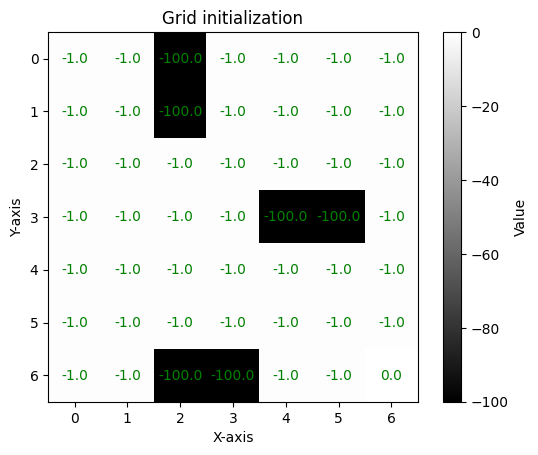

In [13]:
ACTION_UP = 0
ACTION_DOWN = 1
ACTION_LEFT = 2
ACTION_RIGHT = 3
ACTIONS = [ACTION_UP, ACTION_DOWN, ACTION_LEFT, ACTION_RIGHT]
ACTION_SYMBOLS = {ACTION_UP: '↑', ACTION_DOWN: '↓', ACTION_LEFT: '←', ACTION_RIGHT: '→'}

border = f"\n{'='*60}\n"
obstacles = [(0, 2), (1, 2), (3, 4), (3, 5), (6, 2), (6, 3)]
grid, start, end = generate_grid_world(obstacles)
print(border)
visualize_map(grid, "Grid initialization")
print(border)

# Show results
### - Random policy initialization
### - Given

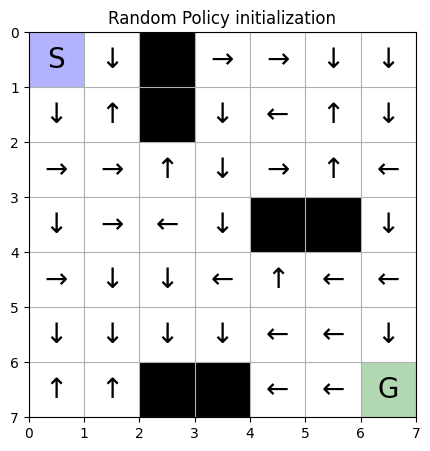

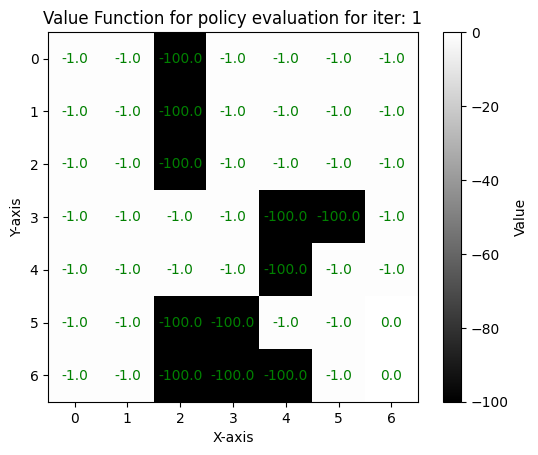

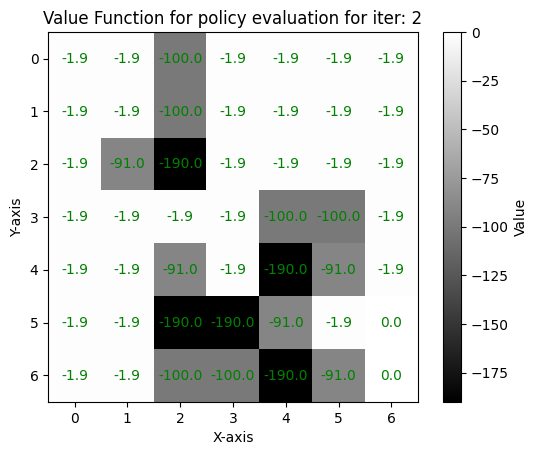

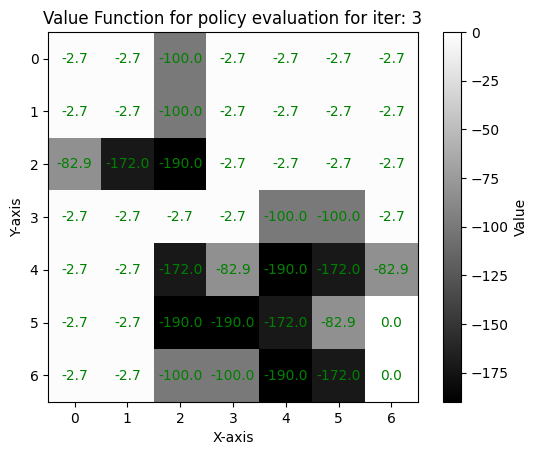

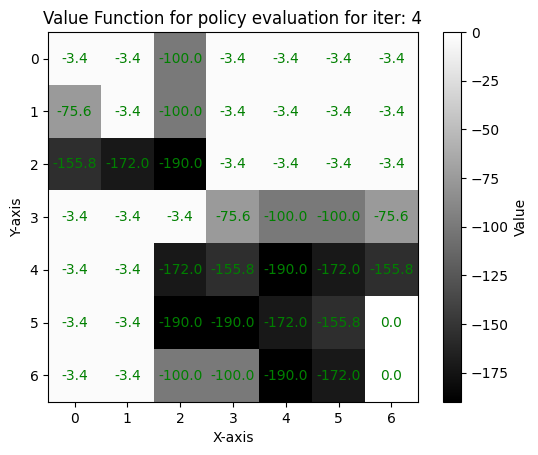

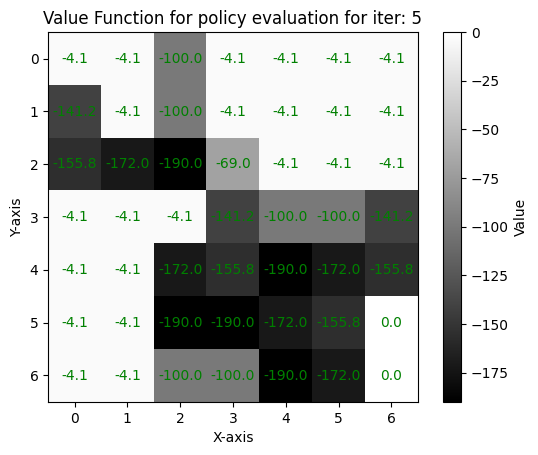

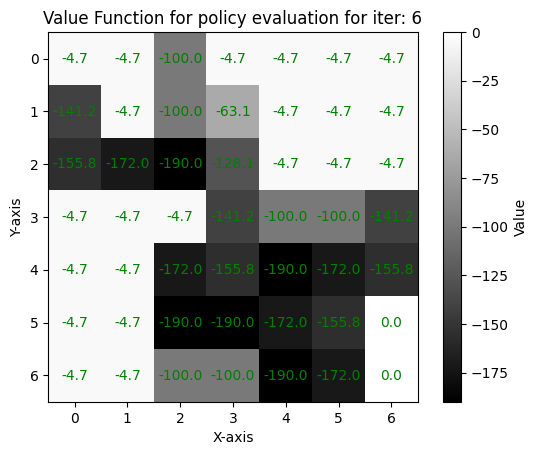

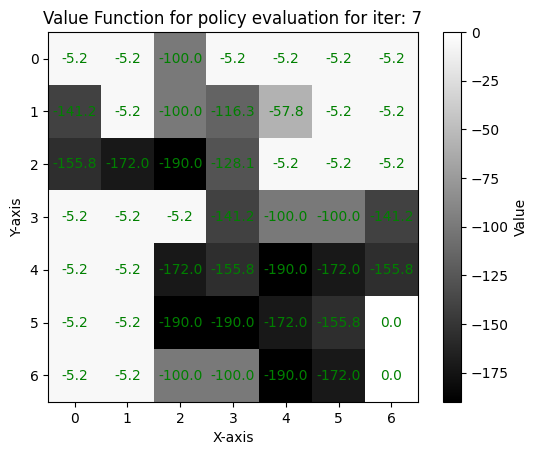

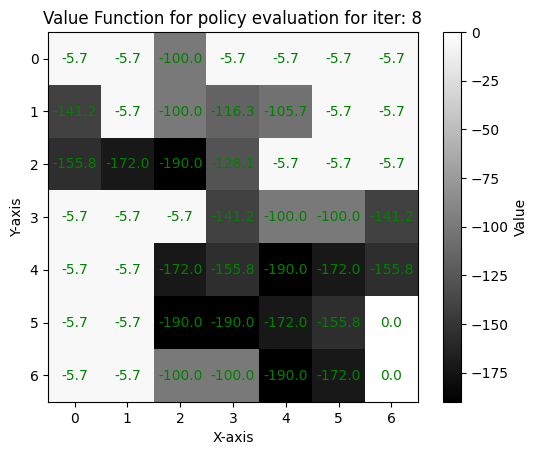

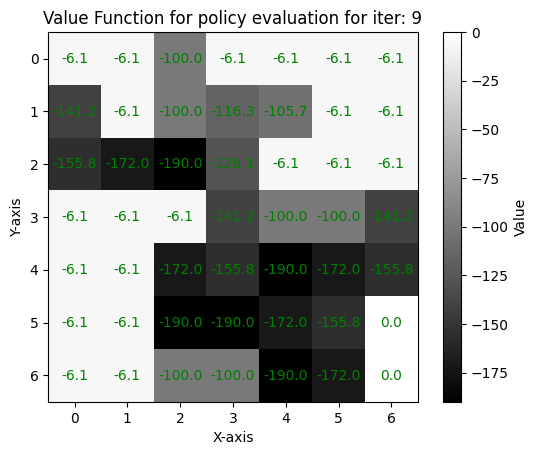

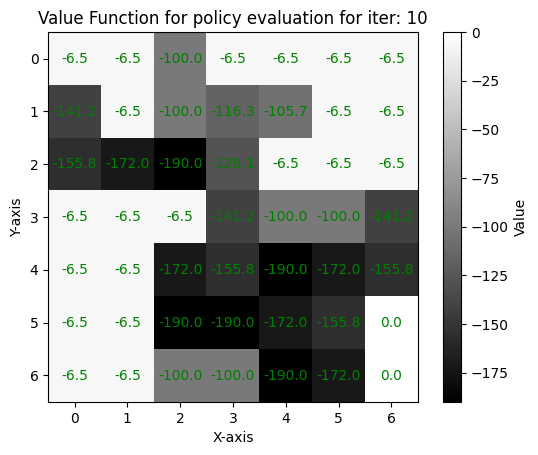

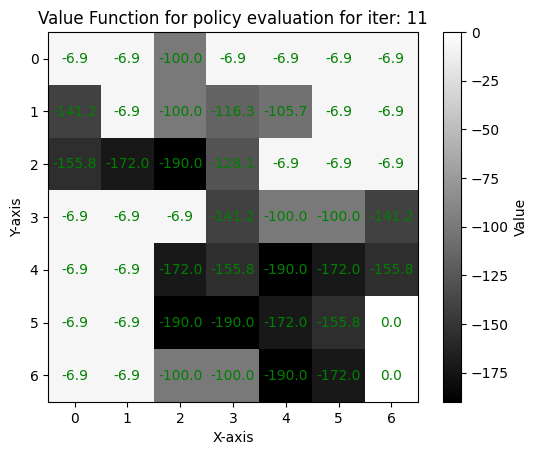

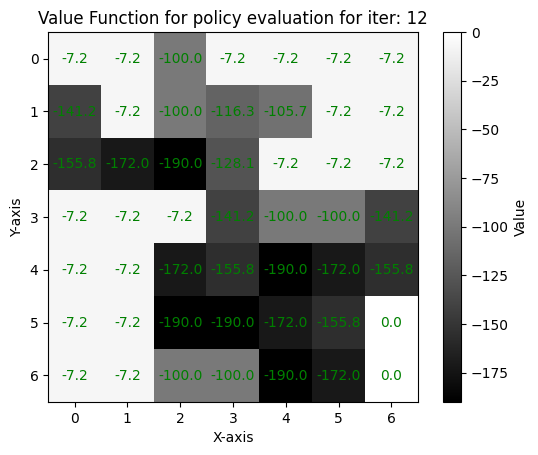

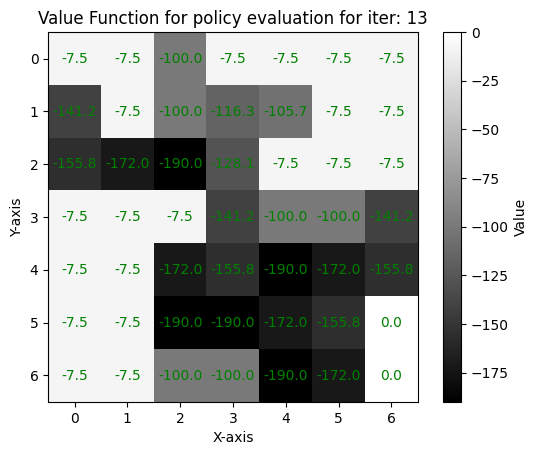

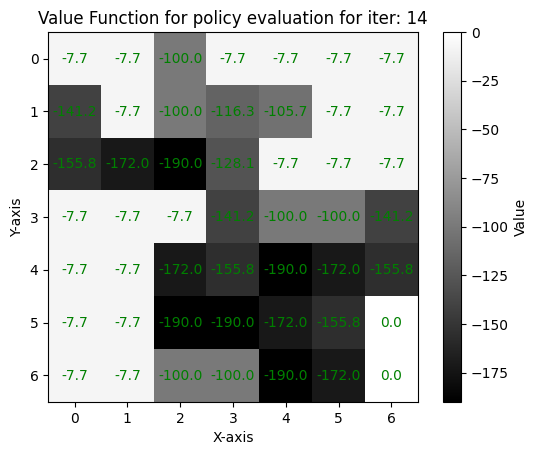

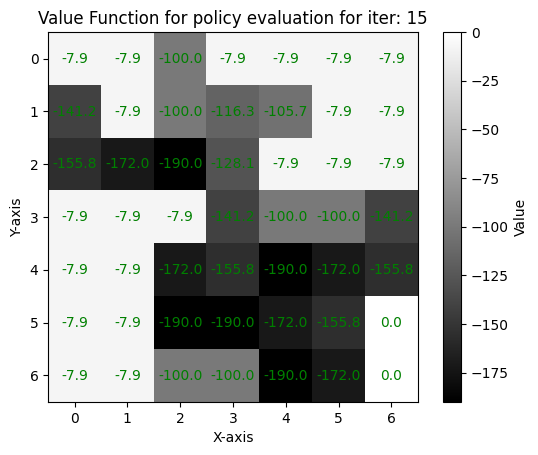

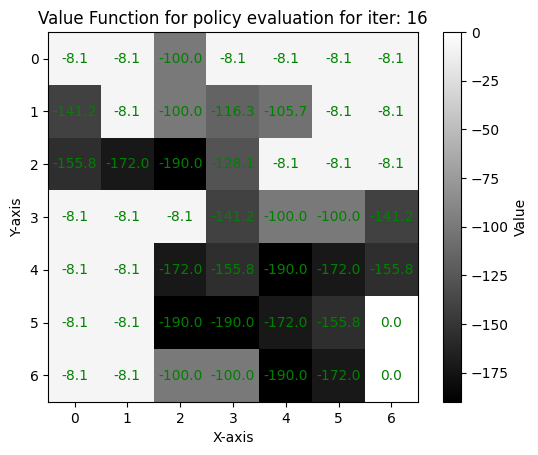

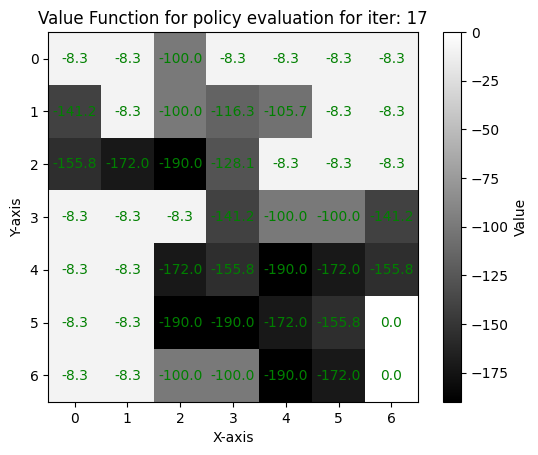

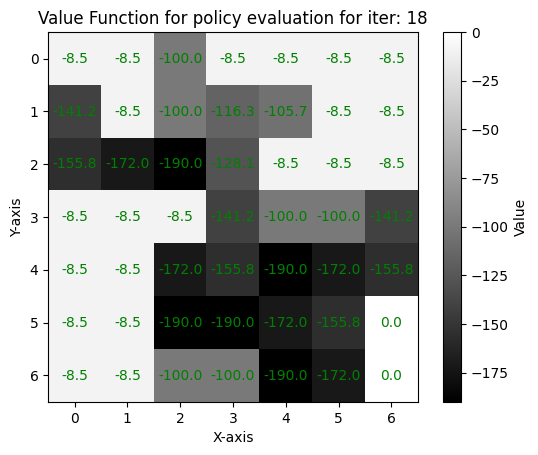

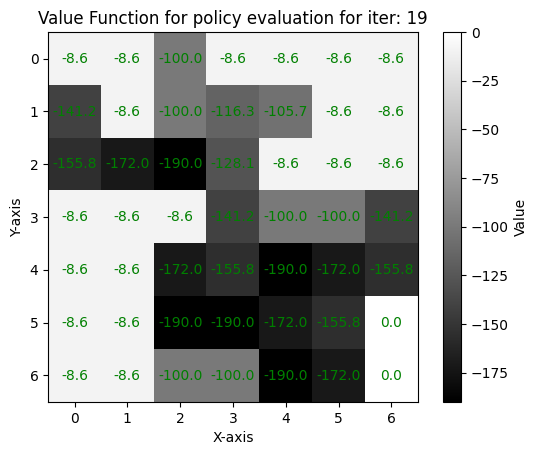

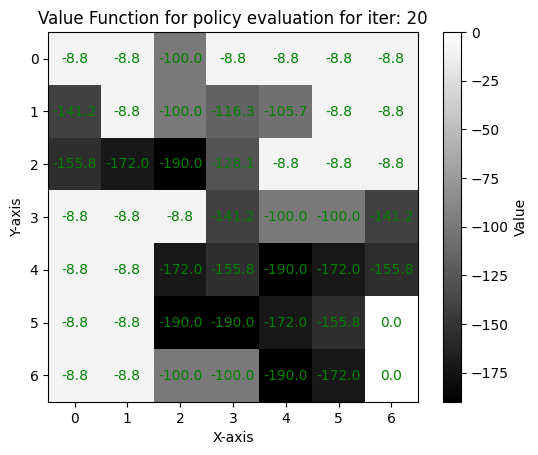

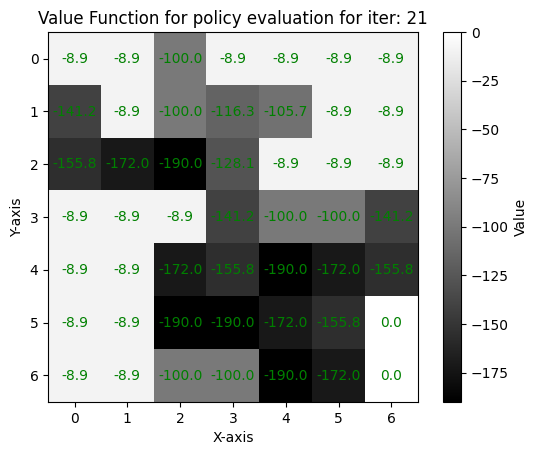

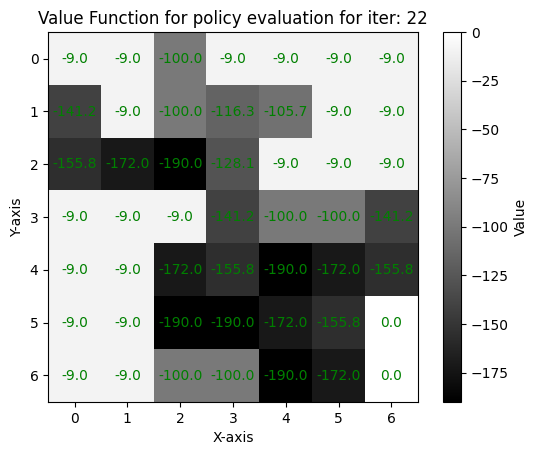

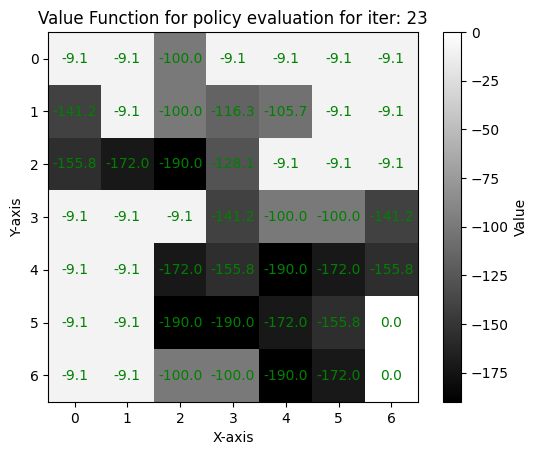

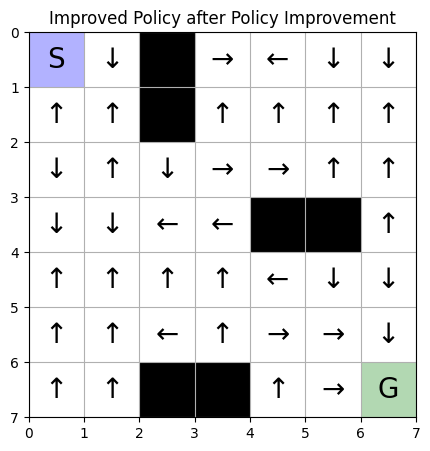

In [14]:
# Policy initialization
random_policy = policy_generator(grid, israndom=True)
visualize_policy(random_policy, start, end, "Random Policy initialization", True)

# Policy evaluation
print(border)
idx = 0
for V_random in policy_evaluation(grid, random_policy, israndom=True):
    idx += 1
    visualize_map(V_random, f"Value Function for policy evaluation for iter: {idx}")
    print(border)

# Policy improvement
improved_policy = policy_improvement(grid, V_random)
visualize_policy(improved_policy, start, end, "Improved Policy after Policy Improvement", True)

# Show results
### - All possible direction policy initialization
### - Given

In [15]:
# Policy initialization
allpossibledirection_policy = policy_generator(grid, israndom=False)
visualize_policy(allpossibledirection_policy, start, end, "All possible direction Policy initialization", False)

# Policy evaluation
print(border)
idx = 0
for V_random in policy_evaluation(grid, allpossibledirection_policy, discount_factor=0.9, israndom=False):
    idx += 1
    visualize_map(V_random, f"Value Function for policy evaluation for iter: {idx}")
    print(border)

# Policy improvement
allpossibledirection_improved_policy = policy_improvement(grid, V_random)
visualize_policy(allpossibledirection_improved_policy, start, end, "Improved Policy after Policy Improvement", False)

ValueError: invalid literal for int() with base 10: '['

# Show results
### - Value iteration
### - Given

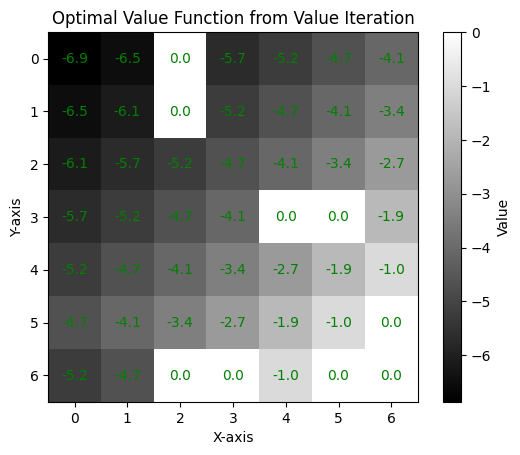

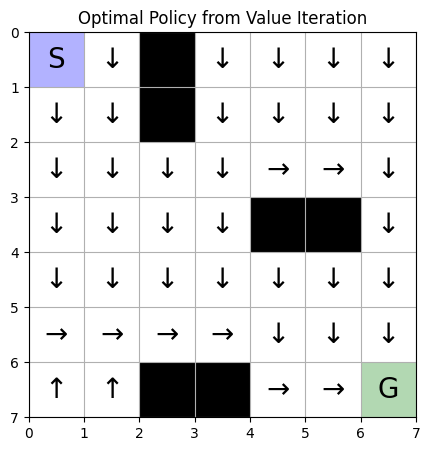

In [16]:
V_opt, optimal_policy = value_iteration(grid)
visualize_map(V_opt, "Optimal Value Function from Value Iteration")

visualize_policy(optimal_policy, start, end, "Optimal Policy from Value Iteration", True)